In [3]:
# use disable_eager_execution() when the you used custom error function
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# future note: if imports show yellow squiggly lines, make sure to also change interpreter with ctrl-shift-p
import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
print(len(x_train))
print(len(x_test))

print(x_train.shape)
print(x_test.shape)

60000
10000
(60000, 28, 28)
(10000, 28, 28)


In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0

In [8]:
image_width = x_train.shape[1]
image_height = x_train.shape[2]

channels = 1
train_batch_size = x_train.shape[0]
test_batch_size = x_test.shape[0]

x_train = x_train.reshape(train_batch_size, image_height, image_width, channels)
x_test = x_test.reshape(test_batch_size, image_height, image_width, channels)

input_shape = (image_height, image_width, channels)

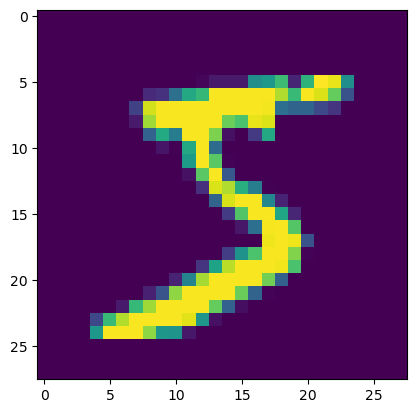

In [9]:
plt.imshow(x_train[0, :, :, :])

In [10]:
from keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K

In [11]:
latent_dimension = 2

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=2)(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x)
print(conv_shape)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)


(None, 14, 14, 64)


In [12]:
z_mu = Dense(latent_dimension, name='latent_mu')(x)
z_sigma = Dense(latent_dimension, name='latent_sigma')(x)

print(K.int_shape(z_mu))
print(K.shape(z_mu)[0])
print(K.int_shape(z_mu)[1])

(None, 2)
Tensor("strided_slice:0", shape=(), dtype=int32)
2


In [13]:
def sample_z(mu_log_variance):
    z_mu, z_sigma = mu_log_variance
    epsilon = K.random_normal(shape=K.shape(z_mu), mean=0.0, stddev=1.0)
    return z_mu + K.exp(z_sigma / 2) * epsilon

z = Lambda(sample_z, name="z")([z_mu, z_sigma])

In [14]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder') # "z_mu, z_sigma, z" are outputs of "encoder" Model
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [15]:
decoder_input = Input(shape=(latent_dimension), name="decoder_input")
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=2)(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='relu', name='decoder_output')(x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

In [16]:
z_decoded = decoder(z)

## Actual Training

In [17]:
from keras.layers import Layer

class CustomLayer(Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        reconstruction_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        KL_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=1)
        return K.mean(reconstruction_loss + KL_loss)
        
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomLayer()([input_img, z_decoded])

In [18]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## VAE

In [19]:

vae = Model(input_img, y, name='vae')
vae.compile(optimizer='adam', loss=None)
vae.summary()

vae.fit(x_train, None, epochs=10, batch_size=32, validation_split=0.2)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                                

c:\Users\Xteve Sing\.conda\envs\tf2.11\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 14s 295us/sample - loss: 0.2497 - val_loss: 0.2273
Epoch 2/10
48000/48000 [==============================] - 7s 154us/sample - loss: 0.2200 - val_loss: 0.2113
Epoch 3/10
48000/48000 [==============================] - 7s 150us/sample - loss: 0.2111 - val_loss: 0.2076
Epoch 4/10
48000/48000 [==============================] - 8s 157us/sample - loss: 0.2128 - val_loss: 0.2053
Epoch 5/10
48000/48000 [==============================] - 8s 158us/sample - loss: 0.2085 - val_loss: 0.2050
Epoch 6/10
48000/48000 [==============================] - 8s 159us/sample - loss: 0.2063 - val_loss: 0.2070
Epoch 7/10
48000/48000 [==============================] - 8s 161us/sample - loss: 0.2054 - val_loss: 0.1998
Epoch 8/10
48000/48000 [==============================] - 7s 151us/sample - loss: 0.2020 - val_loss: 0.1978
Epoch 9/10
48000/48000 [==============================] - 8s 159us/sample - loss: 0.2010 - val_loss: 0.2013
Epoch 10/10
48000/48000 [=============

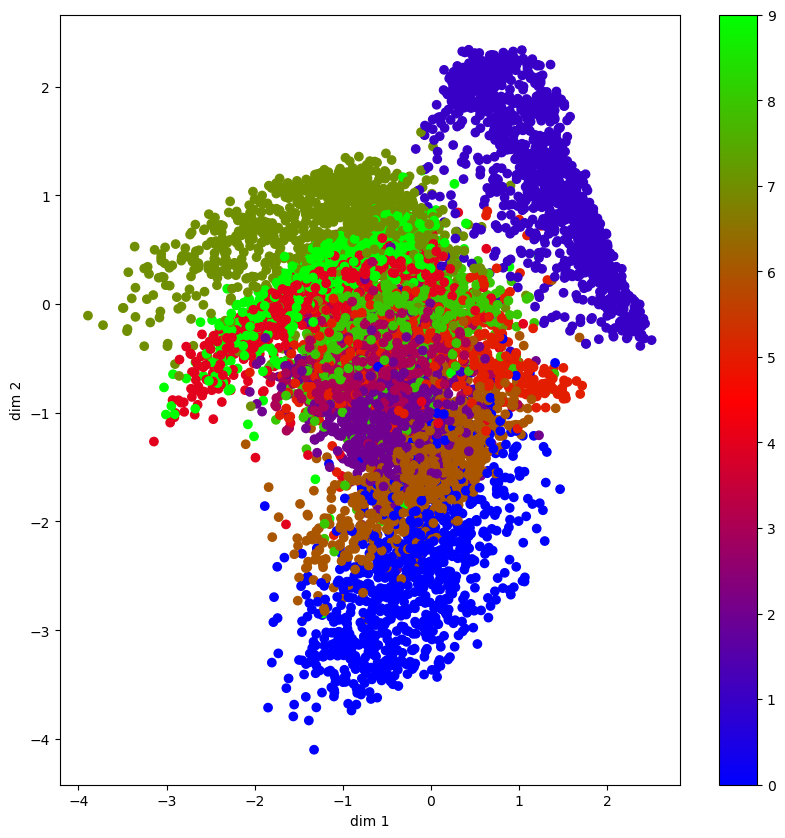

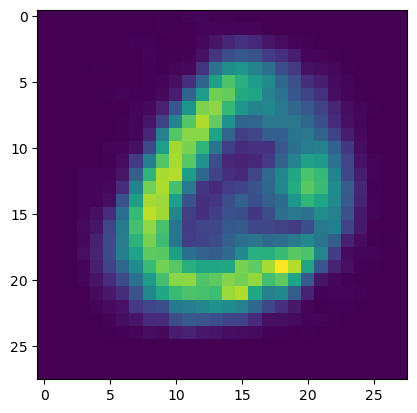

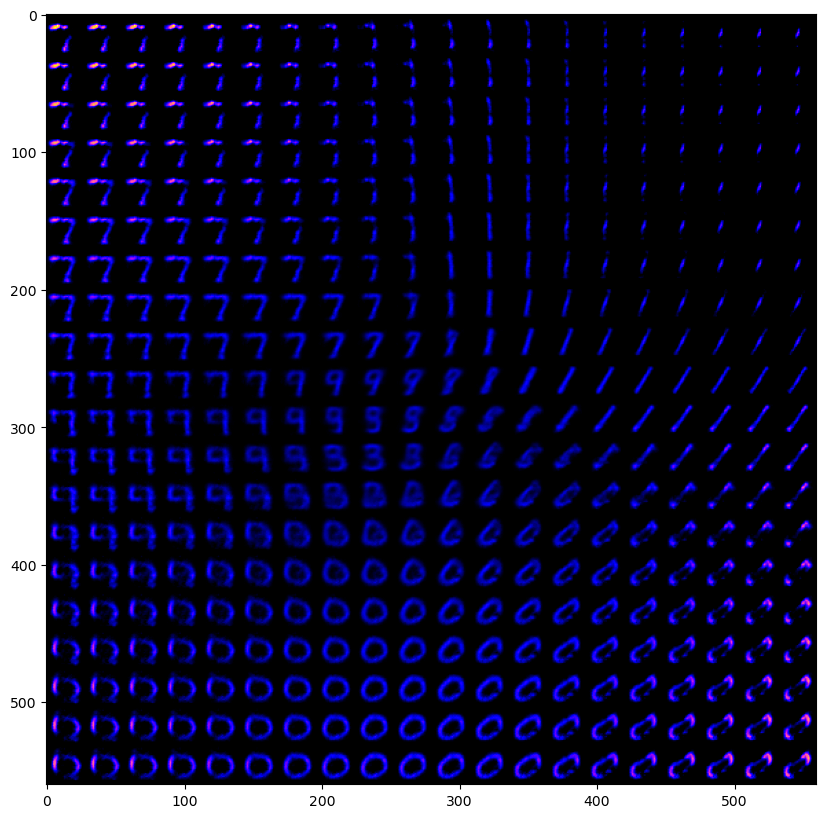

In [21]:
# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()


# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[0,-2]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(image_width, image_height)
plt.imshow(decoded_example_reshaped)

#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


n = 20  # generate 15x15 digits
figure = np.zeros((image_width * n, image_height * n, channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(image_width, image_height, channels)
        figure[i * image_width: (i + 1) * image_width,
               j * image_height: (j + 1) * image_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  